# Laboratorium 4 - rekomendacje dla portali informacyjnych

## Przygotowanie

 * pobierz i wypakuj dataset: https://mind201910small.blob.core.windows.net/release/MINDsmall_train.zip
   * więcej możesz poczytać tutaj: https://learn.microsoft.com/en-us/azure/open-datasets/dataset-microsoft-news
 * [opcjonalnie] Utwórz wirtualne środowisko
 `python3 -m venv ./recsyslab4`
 * zainstaluj potrzebne biblioteki:
 `pip install nltk sklearn`

## Część 1. - przygotowanie danych

In [1]:
# importujemy wszystkie potrzebne pakiety

import codecs
from collections import defaultdict # mozesz uzyc zamiast zwyklego slownika, rozwaz wplyw na czas obliczen
import math
import re
from string import punctuation

import nltk
nltk.download('stopwords')

from nltk.corpus import stopwords
from nltk.stem import RSLPStemmer
from nltk.stem import WordNetLemmatizer
from nltk.stem.lancaster import LancasterStemmer
from nltk.stem.porter import PorterStemmer
from nltk.stem.snowball import SnowballStemmer

import matplotlib.pyplot as plt

# mozesz uzyc do obliczania najbardziej podobnych tekstow zamiast liczenia "na piechote"
# ale pamietaj o dostosowaniu formatu danych
from sklearn.neighbors import NearestNeighbors

# na potrzeby wizualizacji
import matplotlib.pyplot as plt
from wordcloud import WordCloud

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ltmol\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
# definiujemy potrzebne zmienne

PATH = './MINDsmall_train'
STOPWORDS = set(stopwords.words('english'))

In [3]:
# wczytujemy metadane artykułów

def parse_news_entry(entry):
    news_id, category, subcategory, title, abstract = entry.split('\t')[:5]
    return {
        'news_id': news_id,
        'category': category,
        'subcategory': subcategory,
        'title': title,
        'abstract': abstract
    }

def get_news_metadata():
    with codecs.open(f'{PATH}/news.tsv', 'r', 'UTF-8') as f:
        raw = [x for x in f.read().split('\n') if x]
        parsed_entries = [parse_news_entry(entry) for entry in raw]
        return {x['news_id']: x for x in parsed_entries}

news = get_news_metadata()
news_ids = sorted(list(news.keys()))
news_indices = {x[1]: x[0] for x in enumerate(news_ids)}
print(len(news))

51282


In [4]:
def parse_history_entry(entry):
    _id, user_id, _time, history, _impressions = entry.split('\t')
    history = [x for x in history.split() if x]
    return user_id, history

def get_users_history():
    with codecs.open(f'{PATH}/behaviors.tsv', 'r', 'UTF-8') as f:
        lines = [x for x in f.read().split('\n') if x]
        entries = [parse_history_entry(x) for x in lines]
        return dict(entries)

users_history = get_users_history()
test_users = 'U53231', 'U89744', 'U10045', 'U92486', 'U70879'
print(len(users_history))

50000


## Część 2. - TF-IDF

In [5]:
# normalizujemy teksty na potrzeby dalszego przetwarzania

def preprocess_text(text):
    # zamieniamy wszystkie ciagi bialych znakow na pojedyncze spacje
    text = re.sub(r'\s+', ' ', text)
    # usuwamy znaki interpunkcyjne
    text = text.translate(str.maketrans('', '', punctuation))
    # usuwamy wszystkie liczby
    text = re.sub(r'\d+', '', text)
    # podmieniamy wszystkie wielkie litery
    text = text.lower()
    # dzielimy na tokeny
    text = text.split()
    # usuwamy stopwords
    text = [word for word in text if word not in STOPWORDS]

    return text

def stem_texts(corpus):
    stemmer = SnowballStemmer('english') # przetestuj rozne stemmery
    return [[stemmer.stem(word) for word in preprocess_text(text)] for text in corpus]

texts = [news[news_id]['abstract'] for news_id in news_ids]
stemmed_texts = stem_texts(texts)

In [6]:
# porownajmy teksty przed i po przetworzeniu

print(texts[2] + '\n')
print(' '.join(stemmed_texts[2]))

"I think we have a really good team, and a team that can really do some special, good things because that group is very close in there." - Brian Schmetzer

think realli good team team realli special good thing group close brian schmetzer


In [7]:
# tworzymy liste wszystkich slow w korpusie

def get_all_words_sorted(corpus):
    words_set = set([word for words in corpus for word in words])

    words_list = list(words_set)

    words_sorted_list = sorted(words_list)
    return words_sorted_list

wordlist = get_all_words_sorted(stemmed_texts)
word_indices = {x[1]: x[0] for x in enumerate(wordlist)}
print(len(wordlist))

41849


In [8]:
# obliczamy liczbe tekstow, w ktorych wystapilo kazde ze slow
# pamietaj, ze jesli slowo wystapilo w danym tekscie wielokrotnie, to liczymy je tylko raz

def get_document_frequencies(corpus, wordlist):
    # return {word -> count}
    word_dict = defaultdict(int)

    for words in corpus:
        words_set = set(words)
        for word in words_set:
            word_dict[word] += 1    

    return word_dict

document_frequency = get_document_frequencies(stemmed_texts, wordlist)

In [9]:
# obliczamy liczbe wystapien kazdego slowa w kazdym tekscie

def get_term_frequencies(corpus, news_indices):
    # return {news_id -> {word -> count}}
    news_dict = defaultdict(lambda: defaultdict(int))

    for news_id, words in zip(news_indices, corpus):
        news_dict[news_id] = {word: words.count(word) for word in words}

    return news_dict

term_frequency = get_term_frequencies(stemmed_texts, news_indices)

In [10]:
# sprawdzmy wyniki

term_frequency[news_ids[2]]

{'think': 1,
 'realli': 2,
 'good': 2,
 'team': 2,
 'special': 1,
 'thing': 1,
 'group': 1,
 'close': 1,
 'brian': 1,
 'schmetzer': 1}

In [11]:
# obliczamy metryke tf_idf
# Można słownikiem, albo default_dictem. Ale jak brakuje klucze obsłużysz to lepiej zwykłym
#term_frequency -> liczba wystapien kazdego slowa w kazdym tekscie  {news_id -> {word -> count}}
#document_frquency ->  liczba tekstow, w ktorych wystapilo dane slowo {word -> count}
def calculate_tf_idf(term_frequency, document_frequency, corpus_size):
    # return {news_id -> {word -> tf_idf}}

    tf_idf = defaultdict(lambda: defaultdict(float))
    for news_id, words in term_frequency.items():
        for word, frequency in words.items():
            tf_idf[news_id][word] = frequency * math.log(corpus_size / document_frequency[word])
    
    return  tf_idf

tf_idf = calculate_tf_idf(term_frequency, document_frequency, len(news_ids))

In [12]:
# sprawdzmy wyniki

tf_idf[news_ids[2]]

defaultdict(float,
            {'think': 4.360459856758821,
             'realli': 9.707261090572182,
             'good': 8.085400658139525,
             'team': 6.157356388748834,
             'special': 4.765161897298483,
             'thing': 4.111693200556713,
             'group': 4.261685870235309,
             'close': 3.9244235881453897,
             'brian': 5.624739267315748,
             'schmetzer': 9.458800731274183})

## Część 3. - Podobieństwo tekstów

In [13]:
# obliczmy odleglosc miedzy dwoma artykulami
# przetestuj rozne metryki odleglosci i wybierz najlepsza
# Najlepiej wybierz 2 - metryki mogą być cosinusowe, taksówkowe, euklidesowe lub wymyślne

def cosine(v1, v2):
    v1_len = sum([v1[word] ** 2 for word in v1])
    v2_len = sum([v2[word] ** 2 for word in v2])

    common_words = set(v1.keys()) | set(v2.keys())
    
    v1_x_v2 = sum(v1.get(word, 0) * v2.get(word, 0) for word in common_words)

   
    
    return  v1_x_v2 / (math.sqrt(v1_len*v2_len))

def taxi(v1, v2):
    common_words = set(v1.keys()) | set(v2.keys())

    result = sum(abs(v1.get(word, 0) - v2.get(word, 0)) for word in common_words)
    return result

def euclidean(v1, v2):
    all_words = set(v1.keys()) | set(v2.keys())
    vi = sum(((v1.get(word, 0) - v2.get(word, 0))**2 )for word in all_words)
    
    return math.sqrt(vi)

def calculate_distance(tf_idf, id1, id2, method="euclidean"):
    v1 = tf_idf.get(id1)
    v2 = tf_idf.get(id2)

    if method == "euclidean":
        return euclidean(v1, v2) 
    if method == "cosine":
        return cosine(v1, v2) 
    else:
        return taxi(v1, v2)
    

calculate_distance(tf_idf, news_ids[2], news_ids[1])

42.49503805496135

In [14]:
# funkcja pomocnicza do wyswietlania artykulow
def print_news_entry(n_id, corpus):
    print(f'id: {n_id}\n\ttitle: {corpus[n_id]["title"]}\n\ttext: {corpus[n_id]["abstract"]}')

print_news_entry('N42782', news)

id: N42782
	title: Three takeaways from Yankees' ALCS Game 5 victory over the Astros
	text: The Yankees kept hope alive thanks to some impressive starting pitching and a pair of early home runs.


In [15]:
# wyznaczmy k najpodobniejszych tekstow do danego
# pamietaj o odpowiedniej kolejnosci sortowania w zaleznosci od wykorzystanej metryki
# pamietaj, zeby wsrod podobnych tekstow nie bylo danego

def get_k_most_similar_news(tf_idf, n_id, k, method="euclidean"):
    
    similar_dict = {}

    for news_id in tf_idf:
        if (news_id == n_id):
            continue

        similar_dict[news_id] = calculate_distance(tf_idf, n_id, news_id, method)
        
    news_id_list = similar_dict.keys()

    reversed_sort = method == "cosine"
    sorted_news_id = sorted(news_id_list, key=lambda x: similar_dict[x], reverse= reversed_sort)

    return sorted_news_id[:k]

def print_k_most_similar_news(tf_idf, n_id, k, corpus):
    similar = get_k_most_similar_news(tf_idf, n_id, k, "cosine")
    print_news_entry(n_id, corpus)
    print(f'\n{k} most similar:')
    for s_id in similar:
       print_news_entry(s_id, corpus)

print_k_most_similar_news(tf_idf, news_ids[42337], 5, news)

id: N58544
	title: Tiny Electric Car Cost $420,000 To Build
	text: A MAN claims he has created a car that might solve the world's traffic congestion problems. Rick Woodbury from Spokane, Washington USA, is the president, founder and sole employee of 'Commuter Cars.' The carmaker's flagship model is the 2005 super slim two-seater Tango T600, a high-performance electric car that preceded Tesla. Rick told BTV: "I started this company 21 years ago   it was based on an idea that I came up with in 1982." He was inspired by the shocking traffic congestion he had to face on a daily basis. "I used to drive a Porsche from Beverly Hills to Hermosa Beach every day and the traffic was horrendous," explained Rick. What really made Rick think about a solution was the fact that in most of the cars he would see in his commute were occupied by lone drivers. "I noticed that everybody around me was a single occupant in a car, taking up the whole lane," Rick said. Living and working in Los Angeles also hel

## Część 4. - Profile użytkowników

In [16]:
# oblicz srednia z wektorow tf-idf artykulow o zadanych id-kach
def calculate_average_vector(tf_idf, news_ids: list[str]) -> dict[str, float]:

    sum_vector = defaultdict(float)
    for news_id in news_ids:
        vector = tf_idf.get(news_id, {})
    
        for word, value in vector.items():
            sum_vector[word] += value

    num_articles = len(news_ids)
    average_vector = {word: total_value / num_articles for word, total_value in sum_vector.items()}
    
    return average_vector
        
# wykorzystaj powyzsza funkcje, by policzyc wektor kazdego uzytkownika
def calculate_users_vectors(tf_idf, users_history) -> dict[str, list]:
    user_vectors = {}

    for user_id, history in users_history.items():
        if not history:
            user_vectors[user_id] = {}
            continue
        average_vector = calculate_average_vector(tf_idf, history)
        user_vectors[user_id] = average_vector
    return user_vectors

user_vectors = calculate_users_vectors(tf_idf, users_history)


In [17]:
# sprawdz wyliczony profil dla przykladowego uzytkownika
print(sorted([(k,v) for k,v in user_vectors[test_users[0]].items() if v], key=lambda x: -x[1]))

[('fire', 1.267870955689801), ('plane', 1.1701285777724966), ('ditch', 1.0497982187039419), ('diaz', 0.9848359105446637), ('land', 0.8870284483240061), ('paula', 0.8214687066477994), ('acr', 0.8090445060145697), ('ventura', 0.7780260164933531), ('mcconnel', 0.76945001209976), ('flight', 0.7527351413211081), ('maria', 0.7407074421074729), ('hailston', 0.7251391365595806), ('aircraft', 0.7197815043588195), ('storm', 0.6912488475417629), ('chaser', 0.6756286236624416), ('tornado', 0.6380084961613199), ('noaa', 0.6261181107653027), ('report', 0.6253912485455763), ('twoweek', 0.6177050367898467), ('airlin', 0.611710355929694), ('story', 0.6009271210247275), ('contain', 0.5981148110881273), ('california', 0.5954302330209911), ('santa', 0.5734321766843061), ('may', 0.5473113739405064), ('accord', 0.5430078051546358), ('ef', 0.5366350415870621), ('tanker', 0.5317069793379942), ('larg', 0.5301365597954284), ('mandatori', 0.5227667548412794), ('behind', 0.5071744020955066), ('mitch', 0.498135291

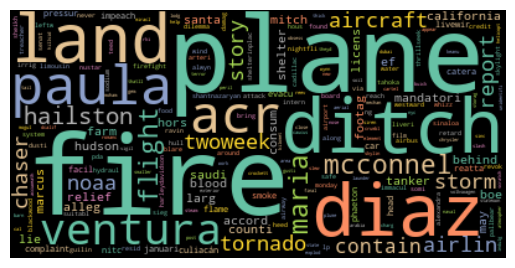

In [18]:
# skorzystajmy ze znanej juz biblioteki, by to lepiej zwizualizowac
def plot_vector(tf_idf_vector):
    wordcloud = WordCloud(random_state=42, background_color='black', colormap='Set2')
    wordcloud.generate_from_frequencies(frequencies=tf_idf_vector)
    plt.figure()
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.show()

plot_vector(user_vectors[test_users[0]])

## Część 5. - Rekomendacje dla użytkowników

-----------------------------
User history:
id: N49179
	title: Joe Alwyn on Buzz Around Taylor Swift Romance: 'I'll Just Turn it Off'
	text: Joe Alwyn on Buzz Around Taylor Swift Romance: 'I'll Just Turn it Off'
id: N13008
	title: Harley-Davidson halts production of new electric motorcycles
	text: Harley-Davidson has halted production and deliveries of its new LiveWire electric motorcycle after reportedly discovering a problem with its charging mechanism.
id: N39498
	title: Why it's so hard for planes to land on water
	text: When US Airways Flight 1549 landed in the Hudson river all 150 passengers survived. Landing a plane on the water is called ditching. Ditching is more common in smaller private planes, not large planes from companies like Boeing or Airbus. But the Miracle on the Hudson isn't the only time an aircraft has been ditched. And despite that success, landing a plane on the water can be extremely dangerous.
id: N37720
	title: 23 Foods That Help Lower High Blood Pressure
	te

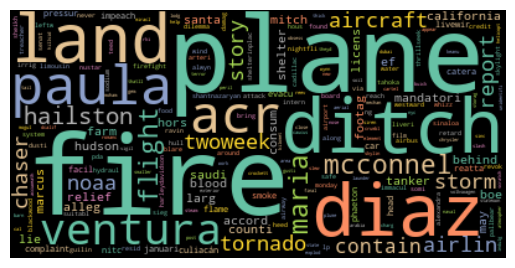

-----------------------------
Recommended news:
id: N22385
	title: Aretha Franklin's former Detroit home is (once again) for sale
	text: This time, for $600,000
id: N54681
	title: Shoei Glamster Helmet Goes Retro In The Most Pleasing Way
	text: Will we get it here?
id: N25412
	title: 3 takeaways from the Bruins' embarrassing shootout loss to the Panthers
	text: "It's on us."
id: N19328
	title: 37-year-old man arrested after vandalizing Joe Montana statue at Levi's stadium
	text: Some people...
id: N24262
	title: Justin Bieber Gives Up His Favorite Beer After Revealing Allergy to Gluten
	text: he just found out


In [19]:
# wykorzystujac wektory tresci i profile uzytkownikow,
#   wygeneruj liste k artykulow najlepiej dopasowanych do uzytkownika
#   pamietaj o odsianiu artykulow, ktore uzytkownik juz kliknal

def recommend(tf_idf, user_id, user_vectors, news, users_history, k, method = "euclidean"):
    # Pobierz wektor użytkownika
    user_vector = user_vectors.get(user_id, {})
    
    # Pobierz historię użytkownika
    user_history = set(users_history.get(user_id, []))

    article_dist_dict = {}
    for news_id, article_vector in tf_idf.items():
        if news_id in user_history:
            continue
        
        if method == "cosine":
            article_dist_dict[news_id] = cosine(user_vector, article_vector)
        elif method == "euclidean":
            article_dist_dict[news_id] = euclidean(user_vector, article_vector)
        else:
            article_dist_dict[news_id] = taxi(user_vector, article_vector)

    articles = article_dist_dict.keys()

    reversed_sort = method == "cosine"
    sorted_articles = sorted(articles, key = lambda x: article_dist_dict[x], reverse=reversed_sort)
    
    return sorted_articles[:k]

# dla wybranego uzytkownika, korzystajac z juz zaimplementowanych funkcji,
#   pokaz jego historie, profil (wordcloud) i rekomendacje

def print_user_history(user_id, users_history, corpus):
    user_history = set(users_history.get(user_id, []))
    print("-----------------------------")
    print("User history:")
    for id in user_history: 
        print_news_entry(id, corpus)

def print_user_profile(user_id, user_vectors):
    print("-----------------------------")
    plot_vector(user_vectors[user_id])


def print_recommended_news(tf_idf, user_id, user_vectors, corpus, users_history, k, method="euclidean"):
    recommended = recommend(tf_idf, user_id, user_vectors, corpus, users_history, k, method)
    print("-----------------------------")
    print("Recommended news:")
    for s_id in recommended:
       print_news_entry(s_id, corpus)

# Przykład użycia
print_user_history(test_users[0], users_history, news)
print_user_profile(test_users[0], user_vectors)
print_recommended_news(tf_idf, test_users[0], user_vectors, news, users_history, k=5)

## Część 6. - Ocena jakości

In [20]:
# jaccard index to metryka podobienstwa zbiorow, lekko ja zmodyfikujemy
# przeciecie wektorow to minimum po kazdej wspolrzednej
# unia wektorow to maksimum po kazdej wspolrzednej
# jaccard index to iloraz sum tych dwoch wartosci

#suma_i min(Ai, Bi)/ suma_i max(Ai,Bi)
def jaccard(v1, v2):

    union_words = set(v1.keys()) | set(v2.keys())

    v_min = {word: min(v1.get(word, 0), v2.get(word, 0)) for word in union_words }
    v_max = {word: max(v1.get(word, 0), v2.get(word, 0)) for word in union_words}
    
    numerator = sum(v_min.values())
    denominator = sum(v_max.values())

    if denominator == 0:
        return 0

    return numerator / denominator


In [21]:
# dla kazdego uzytkownika wygeneruj k-elementowa rekomendacje
# policz jaccard index miedzy wektorem uzytkownika a srednim wektorem elementow z rekomendacji
# porownaj wyniki dla dwoch roznych k i dwoch roznych metryk podobienstwa

def get_recommendations_for_all_users(tf_idf, users_ids, users_history, user_vectors, corpus, k):

    user_recomendation_cosine = {}
    user_recomendation_euclidean = {}
    user_recomendation_taxi = {}

    for user_id in users_ids:
        user_vector = user_vectors.get(user_id)
        # cosine metric
        recommended_cosine = recommend(tf_idf, user_id, user_vectors, corpus, users_history, k, "cosine")
        recommended_cosine_vector_average = calculate_average_vector(tf_idf, recommended_cosine)
        user_recomendation_cosine[user_id] = jaccard(user_vector, recommended_cosine_vector_average)

        # euclidean metric
        recommended_euclidean = recommend(tf_idf, user_id, user_vectors, corpus, users_history, k, "euclidean")
        recommended_euclidean_vector_average = calculate_average_vector(tf_idf, recommended_euclidean)
        user_recomendation_euclidean[user_id] = jaccard(user_vector, recommended_euclidean_vector_average)

        # taxi metric
        recommended_taxi = recommend(tf_idf, user_id, user_vectors, corpus, users_history, k, "taxi")
        recommended_taxi_vector_average = calculate_average_vector(tf_idf, recommended_taxi)
        user_recomendation_taxi[user_id] = jaccard(user_vector, recommended_taxi_vector_average)

        print("Recommended for user: " + str(user_id))
        print("Cosine: " + str(recommended_cosine))
        print("Euclidean: " + str(recommended_euclidean))
        print("Taxi: " +  str(recommended_taxi))
        print("--------------------")

    return user_recomendation_cosine, user_recomendation_euclidean, user_recomendation_taxi

user_recomendation_cosine_5, user_recomendation_euclidean_5, user_recomendation_taxi_5 = get_recommendations_for_all_users(tf_idf, test_users, users_history, user_vectors, news, 5)
user_recomendation_cosine_10, user_recomendation_euclidean_10, user_recomendation_taxi_10 = get_recommendations_for_all_users(tf_idf, test_users, users_history, user_vectors, news, 10)

Recommended for user: U53231
Cosine: ['N58169', 'N58561', 'N31284', 'N43915', 'N37328']
Euclidean: ['N22385', 'N54681', 'N25412', 'N19328', 'N24262']
Taxi: ['N54681', 'N22385', 'N24262', 'N25412', 'N19328']
--------------------
Recommended for user: U89744
Cosine: ['N25062', 'N16282', 'N24105', 'N57549', 'N12112']
Euclidean: ['N22385', 'N54681', 'N25412', 'N19328', 'N41815']
Taxi: ['N22385', 'N54681', 'N25412', 'N19328', 'N41815']
--------------------
Recommended for user: U10045
Cosine: ['N63796', 'N38236', 'N5761', 'N57218', 'N16315']
Euclidean: ['N22385', 'N54681', 'N25412', 'N19328', 'N41815']
Taxi: ['N22385', 'N54681', 'N25412', 'N41815', 'N19328']
--------------------
Recommended for user: U92486
Cosine: ['N58878', 'N34147', 'N64513', 'N51275', 'N41039']
Euclidean: ['N22385', 'N25412', 'N54681', 'N19328', 'N1418']
Taxi: ['N25412', 'N22385', 'N54681', 'N1418', 'N27937']
--------------------
Recommended for user: U70879
Cosine: ['N56704', 'N37092', 'N40194', 'N54926', 'N40995']
Euc

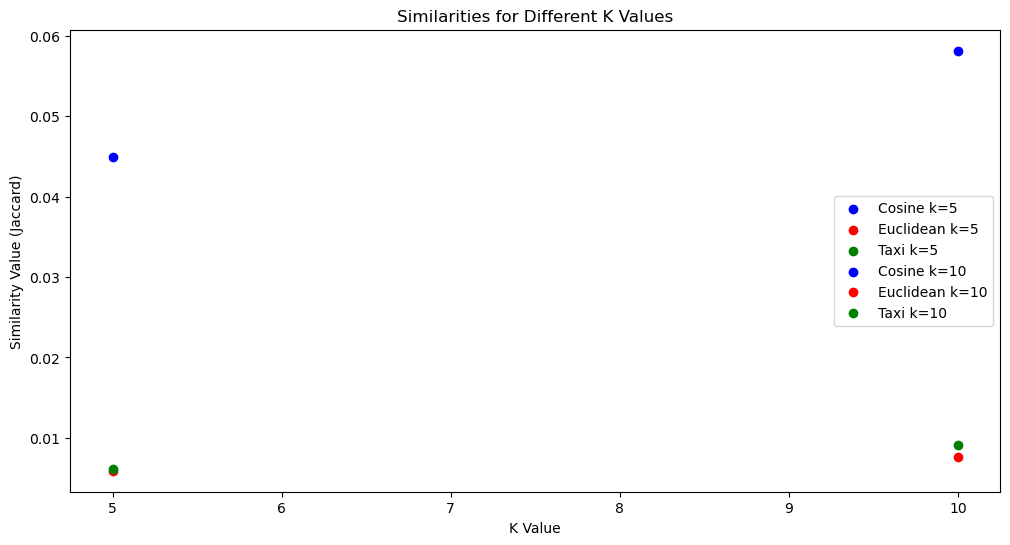

In [22]:
def average(list):
    n = len(list)

    return [sum(list)/n]

def compare(user_recomendation_cosine_5, user_recomendation_euclidean_5, user_recomendation_taxi_5, user_recomendation_cosine_10, user_recomendation_euclidean_10, user_recomendation_taxi_10):

    cosine_5_values = average(list(user_recomendation_cosine_5.values()))
    euclidean_5_values = average(list(user_recomendation_euclidean_5.values()))
    taxi_5_values = average(list(user_recomendation_taxi_5.values()))

    cosine_10_values = average(list(user_recomendation_cosine_10.values()))
    euclidean_10_values = average(list(user_recomendation_euclidean_10.values()))
    taxi_10_values = average(list(user_recomendation_taxi_10.values()))

    k5_values = [5 for _ in range(len(cosine_5_values))]
    k10_values = [10 for _ in range(len(cosine_10_values))]

    plt.figure(figsize=(12, 6))

    plt.scatter(k5_values, cosine_5_values, color='blue', label='Cosine k=5')
    plt.scatter(k5_values, euclidean_5_values, color='red', label='Euclidean k=5')
    plt.scatter(k5_values, taxi_5_values, color='green', label='Taxi k=5')

    plt.scatter(k10_values, cosine_10_values, color='blue', label='Cosine k=10')
    plt.scatter(k10_values, euclidean_10_values, color='red', label='Euclidean k=10')
    plt.scatter(k10_values, taxi_10_values, color='green', label='Taxi k=10')

    plt.xlabel('K Value')
    plt.ylabel('Similarity Value (Jaccard)')
    plt.title('Similarities for Different K Values')
    plt.legend()
    plt.show()

compare(user_recomendation_cosine_5, user_recomendation_euclidean_5, user_recomendation_taxi_5, user_recomendation_cosine_10, user_recomendation_euclidean_10, user_recomendation_taxi_10)